In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from multiprocessing import Process, freeze_support
from PIL import Image

%matplotlib inline

In [2]:
t0 = time.time()
train_dir = '/content/drive/MyDrive/db1/train' #directory with train database
test_dir = '/content/drive/MyDrive/db1/test' #directory with test database
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '/content/drive/MyDrive/db1/train'

In [4]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
    
    '''def __getitem__(self, index):
        return torch.FloatTensor([1.0, 2.0, 3.0])'''
    
    '''def __getitem__(self, idx):
        img = images[idx]
        label = labels[idx]

        return img, label'''
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

In [5]:
dataloaders = torch.utils.data.DataLoader(catdogs, batch_size = 32, shuffle=True, num_workers=2)
print(dataloaders)

In [7]:
device = 'cuda'
model = torchvision.models.densenet121(pretrained=True)

In [8]:
samples, labels = iter(dataloaders).next()

In [9]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

[Epoch 1/3] Iteration 200 -> Train Loss: 0.6079, Accuracy: 0.719
[Epoch 1/3] Iteration 400 -> Train Loss: 0.4029, Accuracy: 0.844
[Epoch 1/3] Iteration 600 -> Train Loss: 0.3173, Accuracy: 0.781
[Epoch 2/3] Iteration 800 -> Train Loss: 0.2428, Accuracy: 0.875
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.2061, Accuracy: 0.938
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.1695, Accuracy: 0.938
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.1561, Accuracy: 0.969
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.1575, Accuracy: 0.906
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.1344, Accuracy: 1.000
[Epoch 3/3] Iteration 2000 -> Train Loss: 0.1155, Accuracy: 0.969
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.1281, Accuracy: 0.969


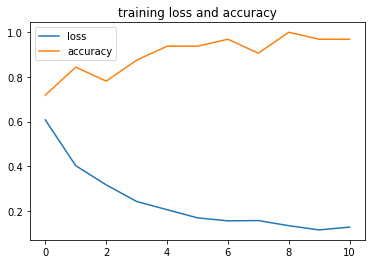

Train time %.3f sec 3221.6249463558197


In [10]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
t1 = time.time()
for epoch in range(epochs):
    for samples, labels in dataloaders:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()
print('Train time %.3f sec', time.time()-t1)

In [ ]:
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle=False, num_workers=2)

In [ ]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]

submission = pd.DataFrame({"id":fn_list, "label":pred_list})
submission.to_csv('preds_densenet121.csv', index=False)

In [ ]:
samples, _ = iter(testloader).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))
plt.show()
print('Total time ', time.time()-t0)